In [27]:
!pip install kaggle

In [28]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
!kaggle datasets download -d f0rtaza/fake-audio

Dataset URL: https://www.kaggle.com/datasets/f0rtaza/fake-audio
License(s): unknown


In [30]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/fake-audio.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [31]:
import numpy as np
import pandas as pd

In [32]:
import librosa

In [47]:
# Function to load and preprocess audio data by extracting features (MFCCs)
def load_and_preprocess_data(audio_path, label):
    # Load the audio file and set sample rate to None to keep it original
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract MFCC (Mel-frequency cepstral coefficients) features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Transpose MFCCs to shape them correctly for model input
    return mfccs.T, label

In [48]:
def prepare_dataset(real_paths, fake_paths):
    X, y = [], []  # X will hold features, y will hold labels (0 for real, 1 for fake)

    # Load real audio files and label them as 0 (real)
    for path in real_paths:
        features, label = load_and_preprocess_data(path, 0)
        X.append(features)
        y.append(label)

    # Load fake audio files and label them as 1 (fake)
    for path in fake_paths:
        features, label = load_and_preprocess_data(path, 1)
        X.append(features)
        y.append(label)

    # Return features (X) and labels (y) as numpy arrays for model compatibility
    return X, np.array(y)

In [62]:
import builtins

# Function to apply data augmentation techniques to the dataset
def augment_data(X, y):
    augmented_X, augmented_y = [], []

    # Loop through each feature set and label
    # Use a different variable name to avoid shadowing the built-in zip function
    for features, label in builtins.zip(X, y):  # Change 'zip' to 'builtins.zip'
        augmented_X.append(features)  # Original features
        augmented_y.append(label)     # Original label

        # Time stretching (simulate by adjusting audio speed before extracting features)
        audio_signal = librosa.effects.time_stretch(features.T[0], rate=0.8)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)

        # Pitch shifting (change pitch slightly for diversity in data)
        audio_signal_shifted = librosa.effects.pitch_shift(features.T[0], sr=22050, n_steps=2)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal_shifted, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)

    # Return augmented features and labels
    return augmented_X, np.array(augmented_y)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.0),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [63]:
# Function to train and evaluate the model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=30, batch_size=32):
    # Train the model and store the training history for plotting
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, verbose=1)

    # Evaluate the model on test data and print test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    # Return the training history to analyze learning progress
    return history

In [52]:
import matplotlib.pyplot as plt

# Function to visualize training and validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [54]:
import os

base_path = "/content/fake_audio"

In [55]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Masking
from sklearn.model_selection import train_test_split

real_paths = [os.path.join(base_path, "real", f) for f in os.listdir(os.path.join(base_path, "real")) if f.endswith('.wav')]
fake_paths = [os.path.join(base_path, "fake", f) for f in os.listdir(os.path.join(base_path, "fake")) if f.endswith('.wav')]

# Prepare and augment the dataset
X, y = prepare_dataset(real_paths, fake_paths)
X_augmented, y_augmented = augment_data(X, y)

# Pad sequences
max_length = max(len(seq) for seq in X_augmented)
X_padded = pad_sequences(X_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_augmented, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=862
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1078
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=862
  warnings.warn(


In [64]:
from sklearn.metrics import classification_report

# Create and train the model
model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = train_and_evaluate(model, X_train, y_train, X_test, y_test)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.4707 - loss: 0.7156 - val_accuracy: 0.6250 - val_loss: 0.6659
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5469 - loss: 0.6865 - val_accuracy: 0.6667 - val_loss: 0.6524
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5795 - loss: 0.6702 - val_accuracy: 0.7083 - val_loss: 0.6187
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6501 - loss: 0.6204 - val_accuracy: 0.7708 - val_loss: 0.5839
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6636 - loss: 0.5995 - val_accuracy: 0.6875 - val_loss: 0.5784
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6238 - loss: 0.6218 - val_accuracy: 0.6667 - val_loss: 0.5652
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6051 - loss: 0.6032 - val_accuracy: 0.7708 - val_loss: 0.5588
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7295 - loss: 0.5264 - val_accuracy: 0.7292 - val_loss: 0.5317

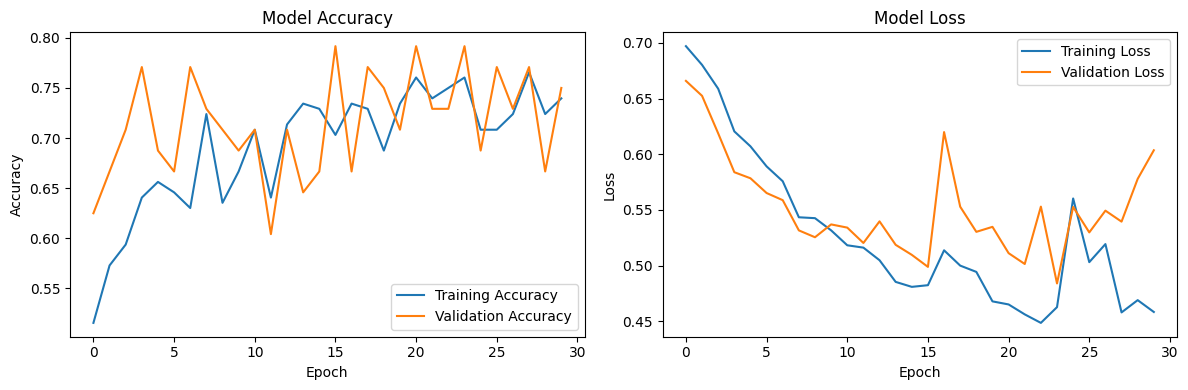

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


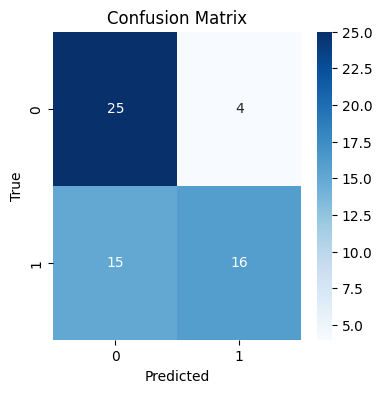

              precision    recall  f1-score   support

           0       0.62      0.86      0.72        29
           1       0.80      0.52      0.63        31

    accuracy                           0.68        60
   macro avg       0.71      0.69      0.68        60
weighted avg       0.72      0.68      0.67        60

Number of real audio samples: 50
Number of fake audio samples: 50
Total number of samples: 100
Shape of padded dataset: (300, 862, 13)
Maximum sequence length: 862
Shape of X_train: (240, 862, 13)
Shape of X_test: (60, 862, 13)


In [65]:
# Visualize the results
plot_training_history(history)

y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Optional: Print dataset statistics
print(f"Number of real audio samples: {len(real_paths)}")
print(f"Number of fake audio samples: {len(fake_paths)}")
print(f"Total number of samples: {len(real_paths) + len(fake_paths)}")
print(f"Shape of padded dataset: {X_padded.shape}")
print(f"Maximum sequence length: {max_length}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

In [66]:
import librosa
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def preprocess_audio(audio_path, max_length):
    # Load the audio
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract MFCC features (use same parameters as training)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Transpose the MFCCs to match the input format
    mfccs = mfccs.T

    # Pad the sequence to the max length used during training
    padded_mfccs = pad_sequences([mfccs], maxlen=max_length, dtype='float32', padding='post', truncating='post')

    return padded_mfccs

In [67]:
test_audio_paths = ['/content/fake_audio/fake/fake2_10.wav', '/content/fake_audio/real/speaker2_9.wav']

for audio_path in test_audio_paths:
    padded_sample = preprocess_audio(audio_path, max_length=X_train.shape[1])
    prediction = model.predict(padded_sample)
    predicted_class = np.argmax(prediction, axis=1)[0]

    if predicted_class == 1:
        print(f"{audio_path}: Fake")
    else:
        print(f"{audio_path}: Real")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
/content/fake_audio/fake/fake2_10.wav: Fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
/content/fake_audio/real/speaker2_9.wav: Real


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"Accuracy: {accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")
print(f"Precision: {precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")
print(f"Recall: {recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")
print(f"f1_score: {f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")

Accuracy: 0.6833
Precision: 0.8000
Recall: 0.5161
f1_score; 0.6275
